In [222]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys 
sys.path.append("/home/anoldfriend/Workspace/MyRepo/openfoamWorkspace/scipyfoam/sciPyFoam")
import polyMesh2d as mesh2d
# import sciPyFoam.polyMesh2d as mesh2d

import os
from colored import fg, bg, attr
import linecache

from matplotlib import ticker
from matplotlib.ticker import MultipleLocator

import vtk
from vtk.util import numpy_support as VN

import proplot as pplot # there are some nice colormaps in the proplot package

C_GREEN = fg('green')
C_RED = fg('red')
C_BLUE = fg('blue')
C_DEFAULT = attr('reset')
#===============================================================

mpl.rcParams['font.family'] = 'Helvetica'  #default font family
mpl.rcParams['mathtext.fontset'] = 'cm' #font for math

import uuid
import traceback
import concurrent.futures

In [74]:
mesh2d.__spec__

ModuleSpec(name='polyMesh2d', loader=<_frozen_importlib_external.SourceFileLoader object at 0x7f139f6a37f0>, origin='/home/anoldfriend/Workspace/MyRepo/openfoamWorkspace/scipyfoam/sciPyFoam/polyMesh2d.py')

In [75]:
caseDir='/home/anoldfriend/OpenFOAM/anoldfriend-7/applications/solvers/cokeCombustionFoam/SegregatedSteps/runs/complicatedPorousMedia/combustions/tiny/convectionLimited'
patchName='frontAndBack'
timeName="0.5"


In [76]:
def get_processor_dirs(caseDir):
    dirs=os.listdir(caseDir)
    procIndexs=[]
    procDirs=[]
    for dir in dirs:
        path=os.path.join(caseDir,dir)
        if(str.startswith(dir,"processor") and os.path.isdir(path) ):
            procIndex=dir.replace("processor",'')
            procIndexs.append(int(procIndex))
    procIndexs=np.sort(np.array(procIndexs))
    for procIndex in procIndexs:
        path=os.path.join(caseDir,f"processor{procIndex}")
        procDirs.append(path)
    return procDirs

procDirs=get_processor_dirs(caseDir)
procDirs
        

['/home/anoldfriend/OpenFOAM/anoldfriend-7/applications/solvers/cokeCombustionFoam/SegregatedSteps/runs/complicatedPorousMedia/combustions/tiny/convectionLimited/processor0',
 '/home/anoldfriend/OpenFOAM/anoldfriend-7/applications/solvers/cokeCombustionFoam/SegregatedSteps/runs/complicatedPorousMedia/combustions/tiny/convectionLimited/processor1',
 '/home/anoldfriend/OpenFOAM/anoldfriend-7/applications/solvers/cokeCombustionFoam/SegregatedSteps/runs/complicatedPorousMedia/combustions/tiny/convectionLimited/processor2',
 '/home/anoldfriend/OpenFOAM/anoldfriend-7/applications/solvers/cokeCombustionFoam/SegregatedSteps/runs/complicatedPorousMedia/combustions/tiny/convectionLimited/processor3',
 '/home/anoldfriend/OpenFOAM/anoldfriend-7/applications/solvers/cokeCombustionFoam/SegregatedSteps/runs/complicatedPorousMedia/combustions/tiny/convectionLimited/processor4',
 '/home/anoldfriend/OpenFOAM/anoldfriend-7/applications/solvers/cokeCombustionFoam/SegregatedSteps/runs/complicatedPorousMedi

In [77]:
def reconstruct_impl(procDirs):
    dfProcGroup=[]
    for procDir in procDirs:
        meshData=mesh2d.getMesh(procDir, patchName)
        xProcs=meshData["x"]
        yProcs=meshData["y"]

        fields=mesh2d.readCellData_to_pointData(procDir, timeName, fieldNames, meshData)
        fields["pointData"]["x"]=xProcs
        fields["pointData"]["y"]=yProcs
        dfProc=pd.DataFrame(fields["pointData"])
        dfProcGroup.append(dfProc)
        
    df=pd.concat(dfProcGroup) 
    df=df.drop_duplicates(subset=["x","y"], keep="first")
    df=df.reset_index(drop=True)
    df.fillna(0,inplace=True)
    return df

In [78]:
def reconstruct(caseDir,timeName,fieldNames):
    patchName='frontAndBack'
    procDirs=get_processor_dirs(caseDir)
    df=reconstruct_impl(procDirs)
    return df

fieldNames=["U","T","p","O2","CO2","eps","cokeRectionRate","Qdot"]
df=reconstruct(caseDir,timeName,fieldNames)
df.head()

,U_0,U_1,U_2,T,p,O2,CO2,eps,x,y,cokeRectionRate,Qdot
0,0.000100,1.734230e-06,0.0,773.752014,1000060.0,0.219936,0.000082,1.0,0.000000,0.0,0.0,0.0
1,0.000097,2.368963e-06,0.0,774.754700,1000060.0,0.219850,0.000191,1.0,0.000001,0.0,0.0,0.0
2,0.000093,2.225517e-06,0.0,776.258606,1000060.0,0.219720,0.000355,1.0,0.000002,0.0,0.0,0.0
3,0.000091,1.073887e-06,0.0,777.762634,1000060.0,0.219591,0.000519,1.0,0.000003,0.0,0.0,0.0
4,0.000093,-4.192230e-07,0.0,779.266052,1000060.0,0.219461,0.000683,1.0,0.000004,0.0,0.0,0.0


In [223]:
import json 
json.dumps(fieldNames)

'["U", "T", "p", "O2", "CO2", "eps", "cokeRectionRate", "Qdot"]'

In [224]:
json.loads('["U", "T", "p", "O2", "CO2", "eps", "cokeRectionRate", "Qdot"]')

['U', 'T', 'p', 'O2', 'CO2', 'eps', 'cokeRectionRate', 'Qdot']

In [132]:
def reconstruct_save(caseDir,timeName,fieldNames,saveFolderPath,overWrite=False):
    try:
        savedFileName=f"{timeName}.csv"
        savedFilePath=os.path.join(saveFolderPath,savedFileName)
        if(os.path.exists(savedFilePath) and not overWrite):
            print(f"Time {timeName}: {timeName} result already exists")
            isSucceed=True
            return timeName,isSucceed
        df=reconstruct(caseDir,timeName,fieldNames)
        df.to_csv(savedFilePath,index=False)
        isSucceed=True
    except Exception as e:
         errmsgs=f"Time {timeName}:\n Unhandler exception happened: {e} with stack trace {traceback.format_exc()}\n"
         print(errmsgs)
         isSucceed=False

    return timeName,isSucceed

In [112]:
timeName=0.5
saveFolderPath=os.path.join(caseDir,"postProcess")
reconstruct_save(caseDir,timeName,fieldNames,saveFolderPath)


(0.5, True)

In [81]:
def tickformatter():
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True) 
    formatter.set_powerlimits((-1,1)) 
    return formatter

def timeStr(time_second):
    Scale,name_time=1,'seconds'
    if(time_second>(86400*365)):
        Scale = 3.17e-08
        name_time='years'
    elif(time_second>86400):
        Scale = 1.1574074074074073e-05
        name_time='days'
    elif(time_second>3600):
        Scale = 0.0002777777777777778
        name_time='hours'
    elif(time_second>60):
        Scale = 0.016666666666666666
        name_time='minutes'
    str_time=str('%.2f %s'%(time_second*Scale,name_time))
    return str_time

def plot_contourf_Impl(X,Y,Z,label,cmap=pplot.Colormap('CoolWarm'),levels=250):
    figwidth=8
    figheight=figwidth/(X.max()-X.min())*(Y.max()-Y.min())
    fig=plt.figure(figsize=(figwidth,figheight))
    ax=plt.gca()
    ax.axis('scaled')
    ax.set_xlim(x.min(),x.max())
    ax.set_ylim(y.min(),y.max())
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    formatter=tickformatter()
    ax.xaxis.set_major_formatter(formatter) 
    ax.yaxis.set_major_formatter(formatter) 
    Xi,Yi=np.meshgrid(X, Y)
    CS=ax.contourf(Xi,Yi,Z, cmap=cmap, levels=levels)
    ax_cb = ax.inset_axes([1.04, 0, 0.02,1])
    plt.colorbar(CS,cax=ax_cb,label=label)
    plt.tight_layout()


def plot_contourf(dfpivot,label,cmap=pplot.Colormap('CoolWarm'),levels=250):
    X=dfpivot.columns.values
    Y=dfpivot.index.values
    Z=dfpivot.values
    plot_contourf_Impl(X,Y,Z,label,cmap=cmap,levels=levels)

def plot_contourf(df,fieldName,label,cmap=pplot.Colormap('CoolWarm'),levels=250):
    dfpivot=df.pivot("y", "x", fieldName)
    X=dfpivot.columns.values
    Y=dfpivot.index.values
    Z=dfpivot.values
    plot_contourf_Impl(X,Y,Z,label,cmap=cmap,levels=levels)


In [217]:
def readData(postProcessDir,timeName):
    fileName=f"{timeName}.csv"
    filePath=os.path.join(postProcessDir,fileName)
    df=pd.read_csv(filePath)
    return df

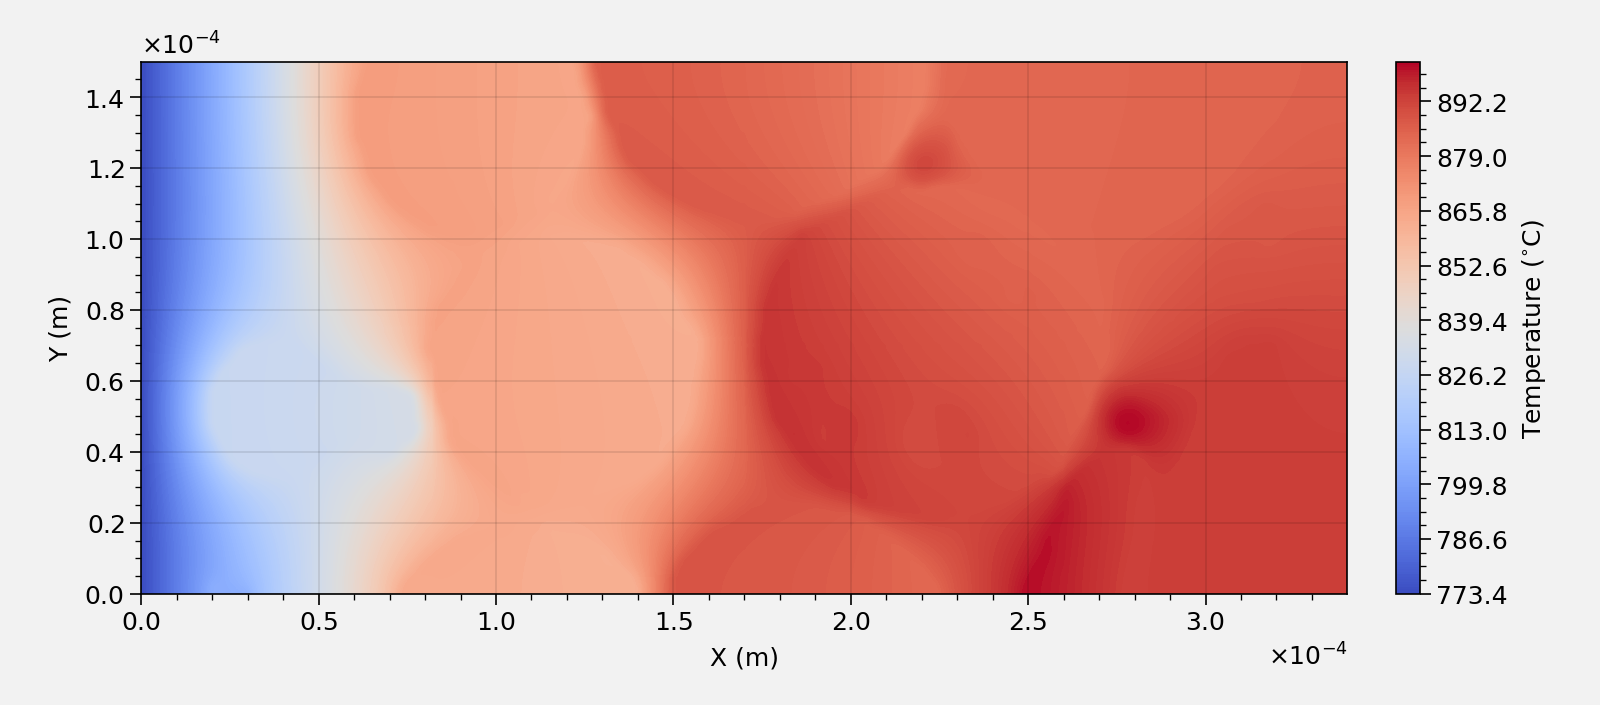

In [83]:
plot_contourf(df,"T",label='Temperature ($^{\circ}$C)')

In [227]:
X.min()

0.0

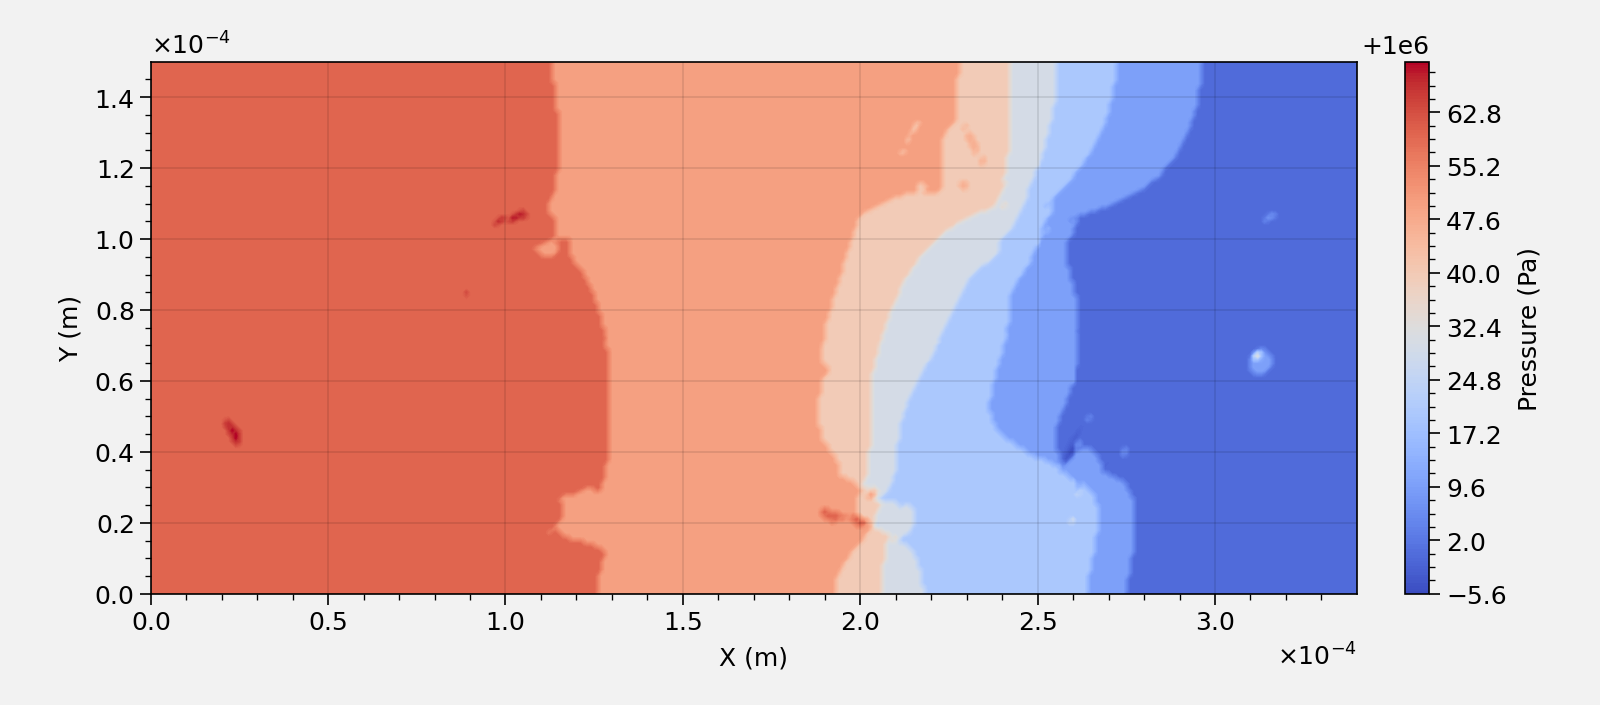

In [84]:
plot_contourf(df,"p",label='Pressure (Pa)')

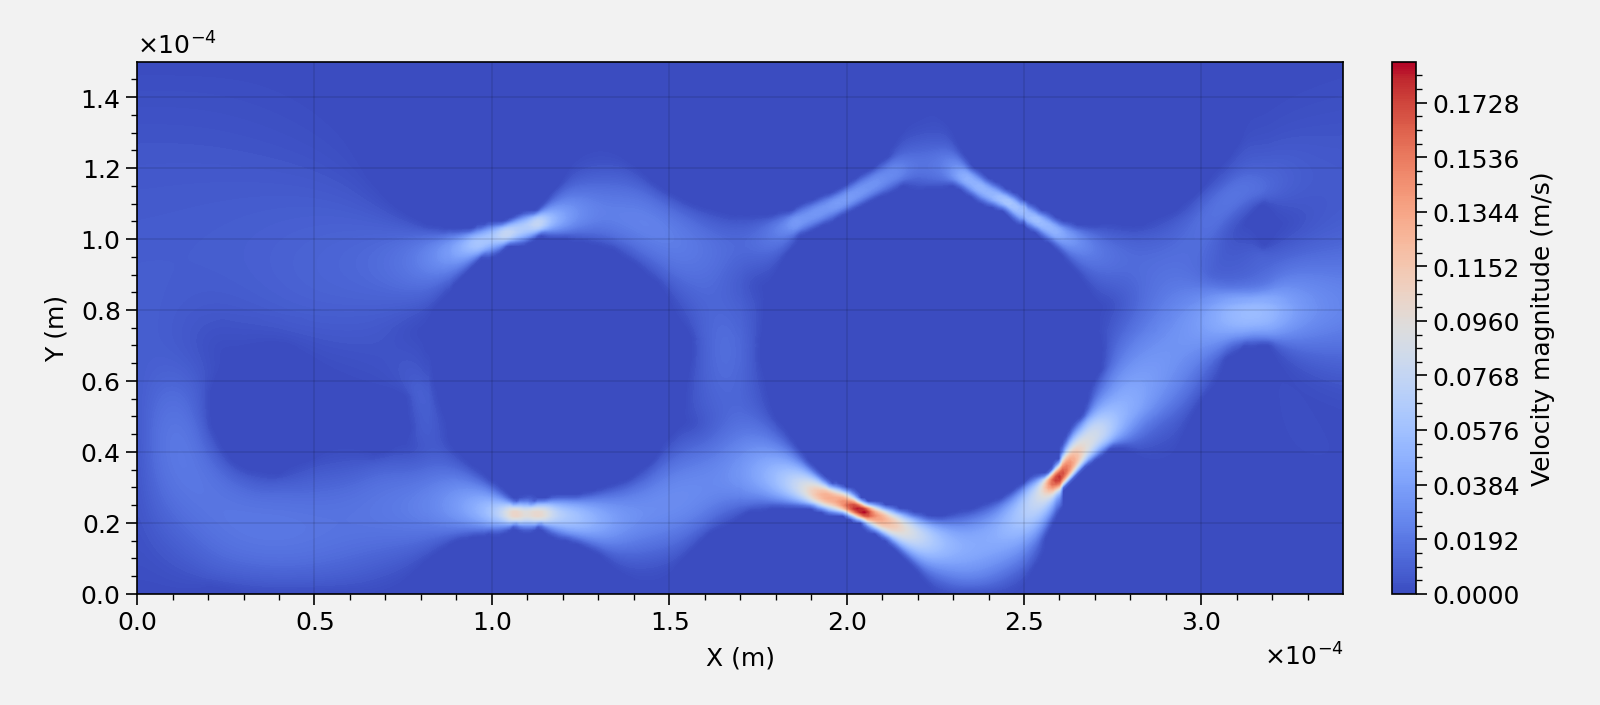

In [85]:
df["UNorm"]=np.sqrt(df['U_0']**2 + df['U_1']**2 + df['U_2']**2)
plot_contourf(df,"UNorm",label='Velocity magnitude (m/s)')

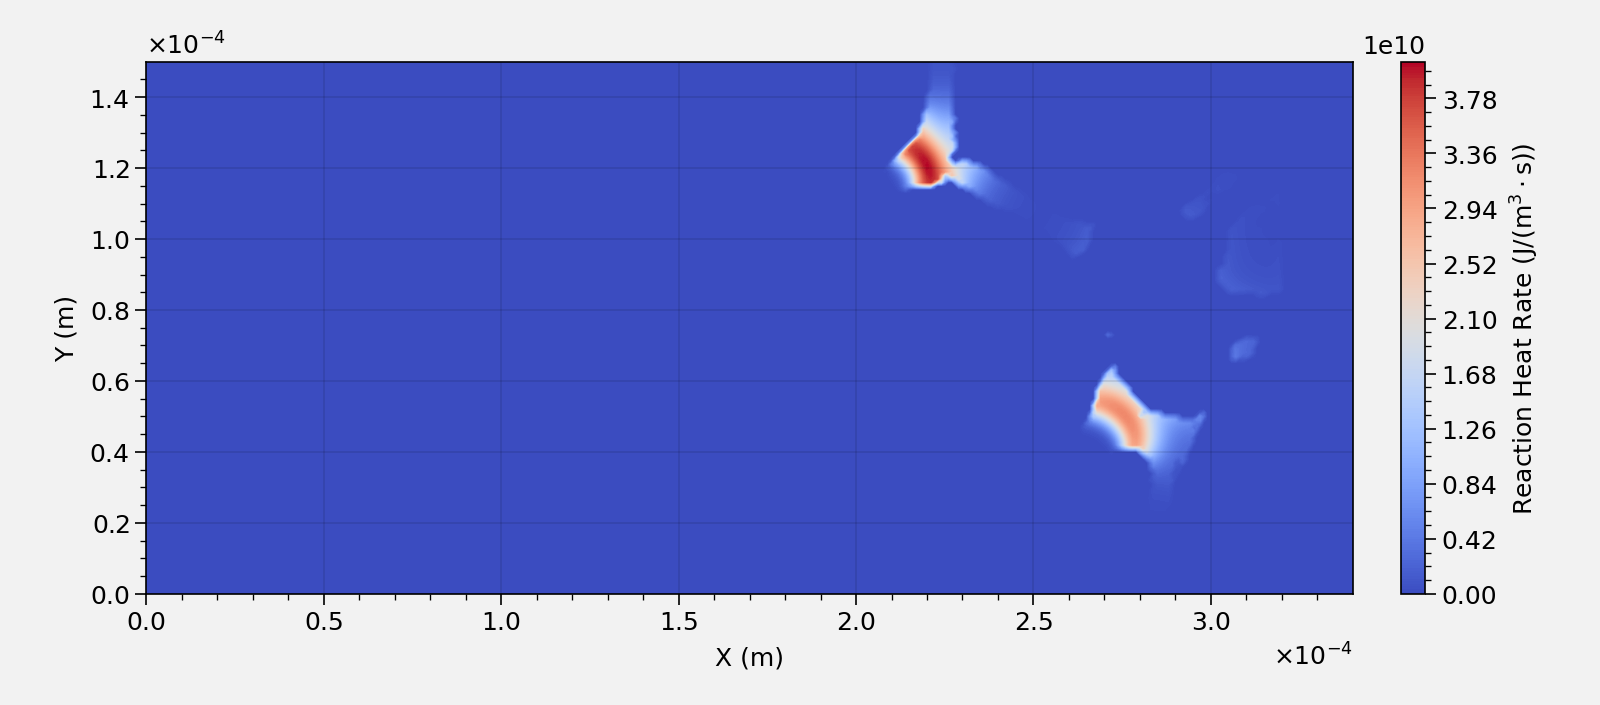

In [86]:
plot_contourf(df,"Qdot",label='Reaction Heat Rate (J/(m$^3\cdot$s))')

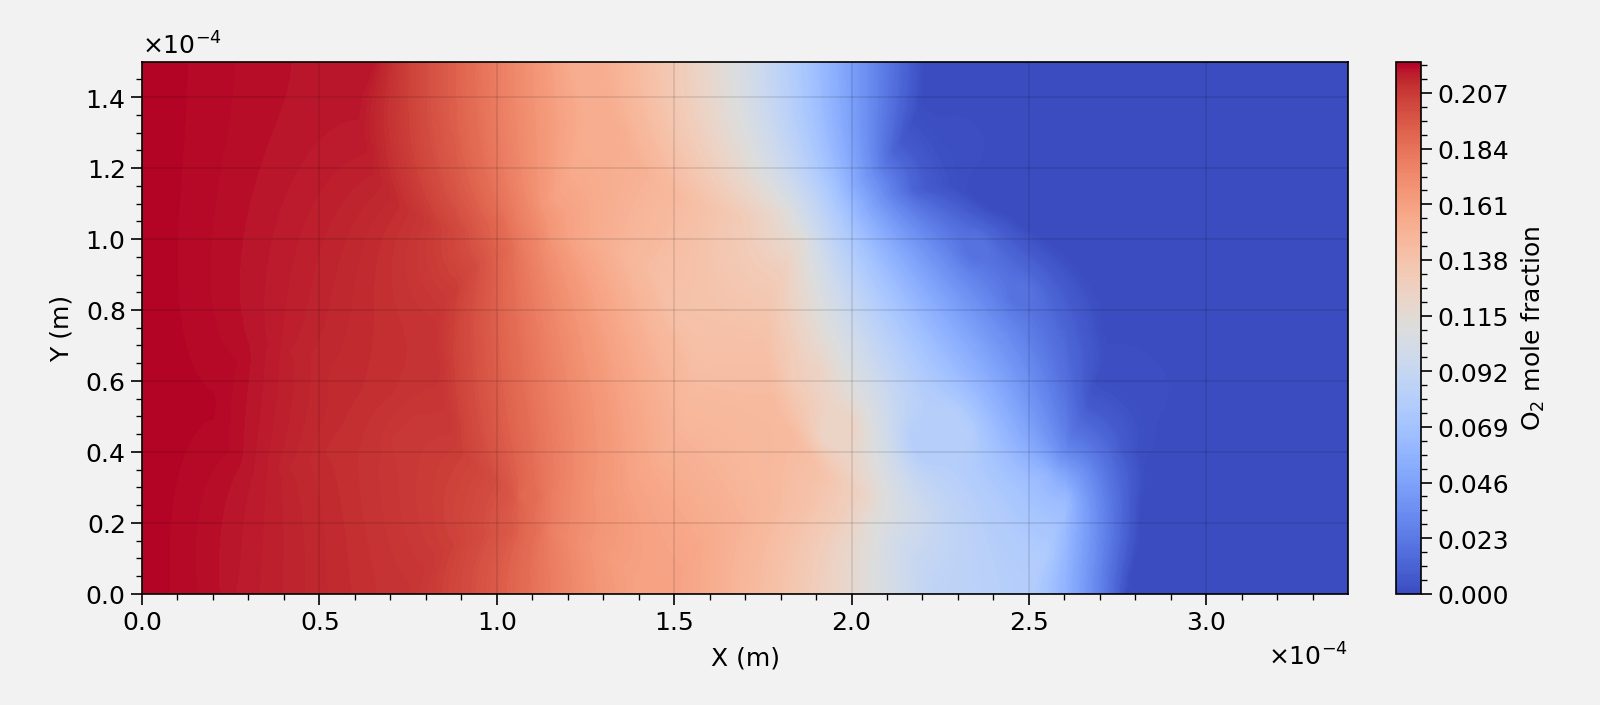

In [87]:
plot_contourf(df,"O2",label='O$_2$ mole fraction')

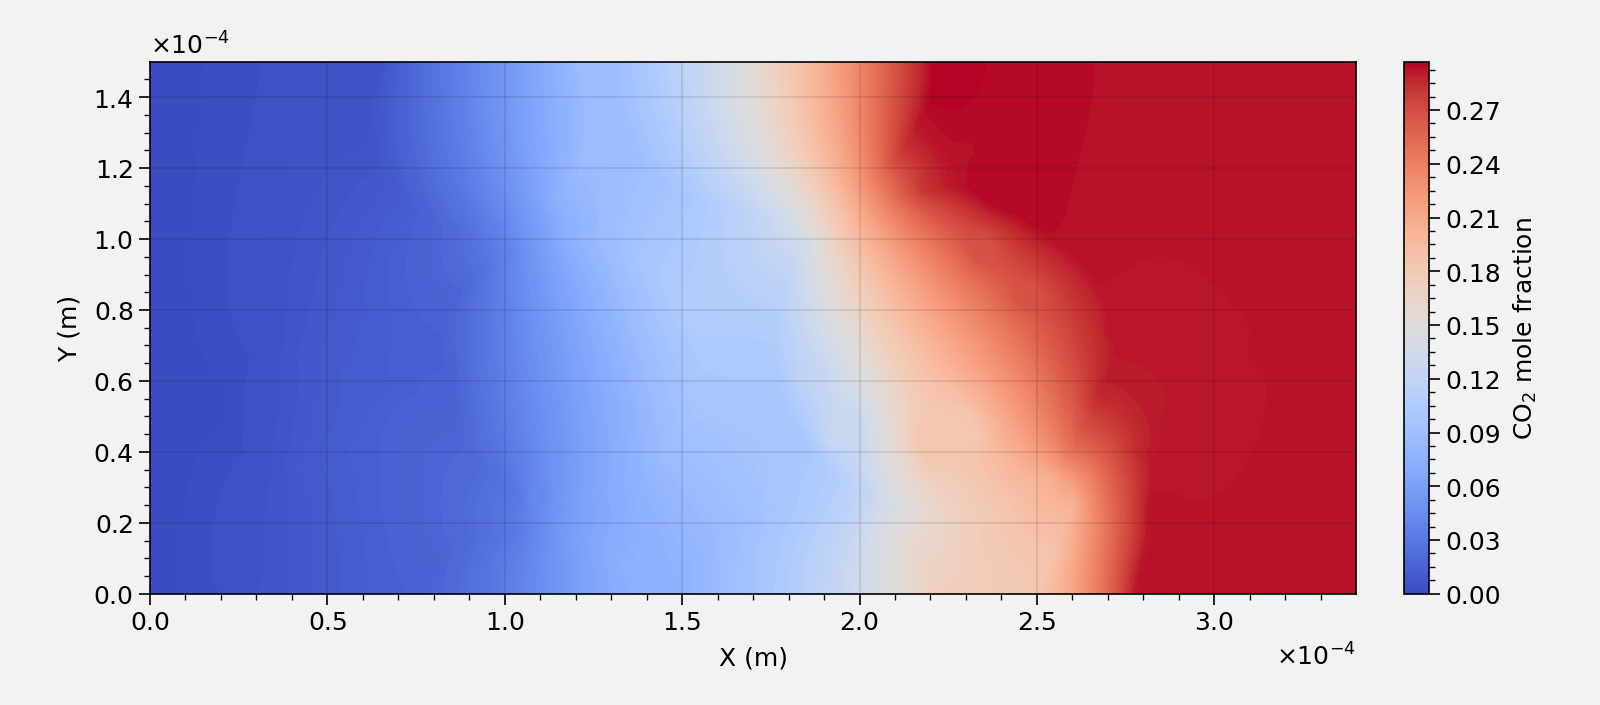

In [88]:
plot_contourf(df,"CO2",label='CO$_2$ mole fraction')

### parallel process

In [101]:
def getTimes(caseDir):
    times=os.listdir(caseDir)
    timeDirs=[]
    for t in times:
        if(os.path.isdir(caseDir+'/'+t)):
            if(t.replace('.','',1).isdigit()):
                timeDirs.append(t)
    #         else:
    #             print(t,'is not a directory')
    timeDirs=np.array(timeDirs)
    times=np.array(timeDirs,dtype=float)
    ind=np.argsort(times)
    return timeDirs[ind],times[ind]

# getTimes(caseDir)

In [118]:
# reconstruct_save(caseDir,timeName,fieldNames)
testTimeNames=['0.01', '0.02', '0.03', '0.04', '0.05']

saveFolder="postProcess"
saveFolderPath=os.path.join(caseDir,saveFolder)
if not os.path.exists(saveFolderPath):
    os.mkdir(saveFolderPath)
if not os.path.isdir(saveFolderPath):
    saveFolderPath="{saveFolderPath}_str(uuid.uuid4())[:8]"
    os.mkdir(saveFolderPath)
print(f"saving folder path: {saveFolderPath}")


saving folder path: /home/anoldfriend/OpenFOAM/anoldfriend-7/applications/solvers/cokeCombustionFoam/SegregatedSteps/runs/complicatedPorousMedia/combustions/tiny/convectionLimited/postProcess


In [176]:
sampleRate=5
allTimeNames,_=getTimes(caseDir)
allTimeNames=allTimeNames[allTimeNames!='0']
indexs=np.arange(0,allTimeNames.shape[0])
allTimeNames[indexs%sampleRate==0]
# allTimeNames.Indexs
# allTimeNames[allTimeNames.index%2]


array(['0.01', '0.06', '0.11', '0.16', '0.21', '0.26', '0.31', '0.36',
       '0.41', '0.46', '0.51', '0.56', '0.61', '0.66', '0.71', '0.76',
       '0.81', '0.86', '0.91', '0.96', '1.01', '1.06', '1.11', '1.16',
       '1.21', '1.26', '1.31', '1.36', '1.41', '1.46', '1.51', '1.56',
       '1.61', '1.66', '1.71', '1.76', '1.81', '1.86', '1.91'],
      dtype='<U4')

In [213]:
def reconstruct_all(caseDir,fieldNames,worker=8,saveFolder="postProcess",sampleRate=1,overWrite=False):
    processor0Dir=os.path.join(caseDir,"processor0")
    if not os.path.exists(processor0Dir):
        print("Error: no processor dir exists!")
        return ""

    allTimeNames,_=getTimes(processor0Dir)
    allTimeNames=allTimeNames[allTimeNames!='0']
    indexs=np.arange(0,allTimeNames.shape[0])
    sampleTimeNames=allTimeNames[indexs%sampleRate==0]
    print(f"sample time names: {sampleTimeNames}")

    saveFolderPath=os.path.join(caseDir,saveFolder)
    if not os.path.exists(saveFolderPath):
        os.mkdir(saveFolderPath)
    if not os.path.isdir(saveFolderPath):
        saveFolderPath="{saveFolderPath}_str(uuid.uuid4())[:8]"
        os.mkdir(saveFolderPath)
    print(f"saving folder path: {saveFolderPath}")

    futures=list()
    dict_status={"timeName":[],"isSucceed":[]}
    with concurrent.futures.ProcessPoolExecutor(max_workers=worker) as executor:
        print("start to map...")
        for timeName in sampleTimeNames:
            future=executor.submit(reconstruct_save,caseDir,timeName,fieldNames,saveFolderPath,overWrite)
            futures.append(future)
        print("start to reduce...")
        for _, future in enumerate(futures):
            returnedTimeName,isSucceed=future.result()
            dict_status["timeName"].append(returnedTimeName)
            dict_status["isSucceed"].append(isSucceed)
        df_status=pd.DataFrame(dict_status)

    df_succeed=df_status[df_status["isSucceed"]==True]
    df_failed=df_status[df_status["isSucceed"]!=True]
    succeedNum=np.sum(df_succeed["isSucceed"])
    print(f"succced number: {succeedNum}")
    failedNum=np.sum(df_failed["isSucceed"])
    print(f"failed number: {failedNum}")
    if failedNum:
        failedTimeName=df_failed["timeName"]
        print(f"failed time name:\n {failedTimeName}")

    return saveFolderPath


In [203]:
reconstruct_all(caseDir,fieldNames,sampleRate=1)

sample time names: ['0.001' '0.002' '0.003' '0.004' '0.005' '0.006' '0.007' '0.008' '0.009'
 '0.01' '0.02' '0.03' '0.04' '0.05' '0.06' '0.07' '0.08' '0.09' '0.1'
 '0.11' '0.12' '0.13' '0.14' '0.15' '0.16' '0.17' '0.18' '0.19' '0.2'
 '0.21' '0.22' '0.23' '0.24' '0.25' '0.26' '0.27' '0.28' '0.29' '0.3'
 '0.31' '0.32' '0.33' '0.34' '0.35' '0.36' '0.37' '0.38' '0.39' '0.4'
 '0.41' '0.42' '0.43' '0.44' '0.45' '0.46' '0.47' '0.48' '0.49' '0.5'
 '0.51' '0.52' '0.53' '0.54' '0.55' '0.56' '0.57' '0.58' '0.59' '0.6'
 '0.61' '0.62' '0.63' '0.64' '0.65' '0.66' '0.67' '0.68' '0.69' '0.7'
 '0.71' '0.72' '0.73' '0.74' '0.75' '0.76' '0.77' '0.78' '0.79' '0.8'
 '0.81' '0.82' '0.83' '0.84' '0.85' '0.86' '0.87' '0.88' '0.89' '0.9'
 '0.91' '0.92' '0.93' '0.94' '0.95' '0.96' '0.97' '0.98' '0.99' '1' '1.01'
 '1.02' '1.03' '1.04' '1.05' '1.06' '1.07' '1.08' '1.09' '1.1' '1.11'
 '1.12' '1.13' '1.14' '1.15' '1.16' '1.17' '1.18' '1.19' '1.2' '1.21'
 '1.22' '1.23' '1.24' '1.25' '1.26' '1.27' '1.28' '1.29' '1.3' 

In [215]:
newCaseDir="/home/anoldfriend/OpenFOAM/anoldfriend-7/applications/solvers/cokeCombustionFoam/SegregatedSteps/runs/complicatedPorousMedia/combustions/optimize/tiny2_6"
saveFolderPath=reconstruct_all(newCaseDir,fieldNames,sampleRate=1)
saveFolderPath

sample time names: ['0.01' '0.02' '0.03' '0.04' '0.05' '0.06' '0.07' '0.08' '0.09' '0.1']
saving folder path: /home/anoldfriend/OpenFOAM/anoldfriend-7/applications/solvers/cokeCombustionFoam/SegregatedSteps/runs/complicatedPorousMedia/combustions/optimize/tiny2_6/postProcess
start to map...
Time 0.01: 0.01 result already existsTime 0.02: 0.02 result already existsTime 0.03: 0.03 result already exists
Time 0.04: 0.04 result already exists
Time 0.05: 0.05 result already existsTime 0.06: 0.06 result already exists
Time 0.08: 0.08 result already existsTime 0.07: 0.07 result already exists
Time 0.09: 0.09 result already existsTime 0.1: 0.1 result already exists





start to reduce...
succced number: 10
failed number: 0


'/home/anoldfriend/OpenFOAM/anoldfriend-7/applications/solvers/cokeCombustionFoam/SegregatedSteps/runs/complicatedPorousMedia/combustions/optimize/tiny2_6/postProcess'

In [218]:
df2=readData(saveFolderPath,"0.1")
df2.head()

,U_0,U_1,U_2,T,p,O2,CO2,eps,cokeRectionRate,Qdot,x,y
0,0.005094,0.001382,0.0,775.51400,1000670.0,0.219633,0.000504,1.0,0.0,0.0,0.000000,0.0
1,0.005070,0.003047,0.0,778.86800,1000670.0,0.219142,0.001178,1.0,0.0,0.0,0.000001,0.0
2,0.004980,0.005363,0.0,783.90106,1000670.0,0.218406,0.002189,1.0,0.0,0.0,0.000002,0.0
3,0.004822,0.007407,0.0,788.93570,1000670.0,0.217675,0.003194,1.0,0.0,0.0,0.000003,0.0
4,0.004609,0.009179,0.0,793.97064,1000670.0,0.216952,0.004188,1.0,0.0,0.0,0.000004,0.0


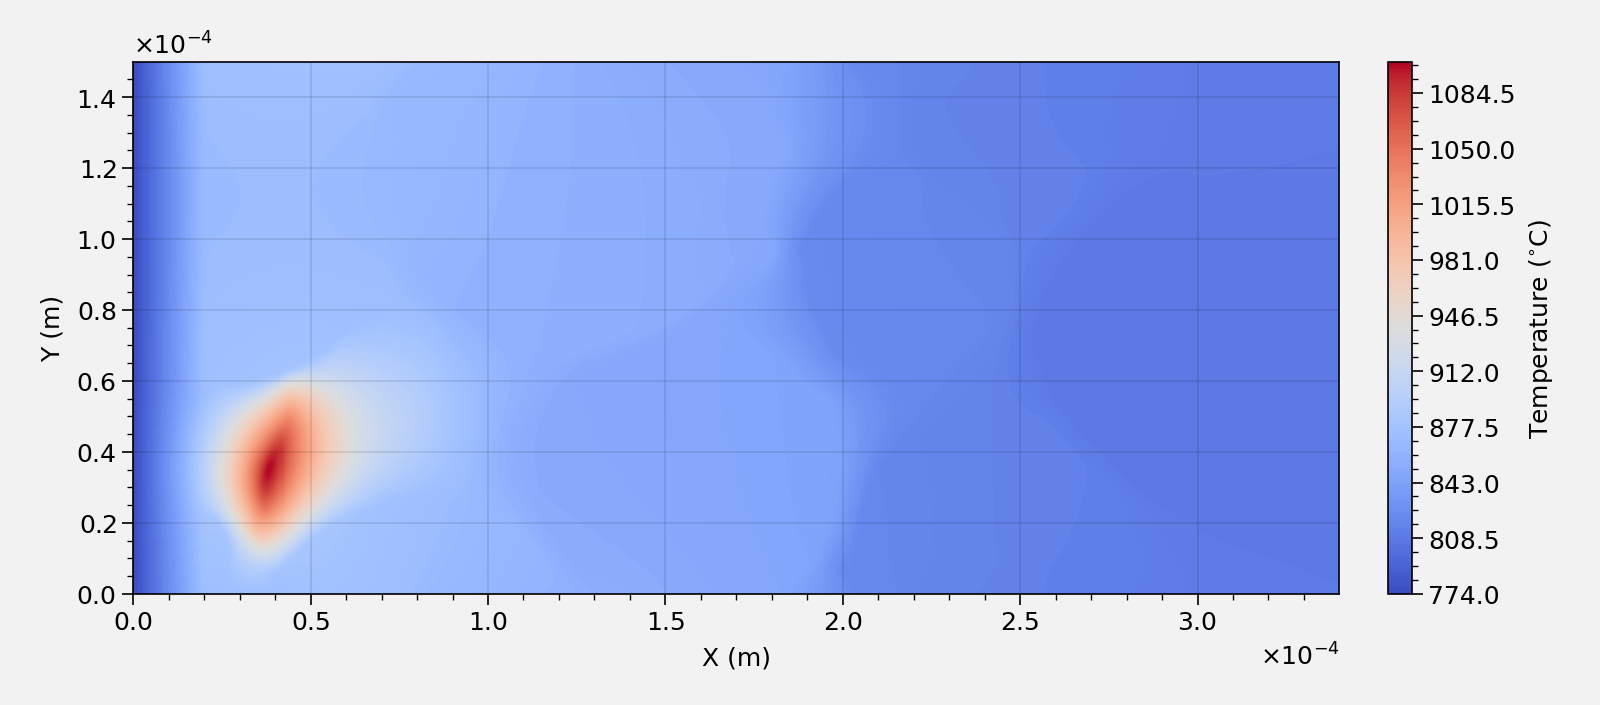

In [221]:
plot_contourf(df2,"T",label='Temperature ($^{\circ}$C)')